# Prediction of the function development using RNNs and its comparsion with other NNs

In this work I would like to use various neural network models to predict future price of BTC based on various cryptocurrency prices.  

### Importing libraries

I am going to use tensorflow and other libraries.

In [1]:
# disable gpu
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


## Uncomment w
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
import glob
import joblib

In [4]:
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.grid'] = False

#### parameters

In [5]:
RATIO_TO_PREDICT = "BTCBUSD"
FUTURE_PERIOD_PREDICT = 2

## Loading data

Load csv files obtained using binance API

In [6]:
main_df = pd.DataFrame()

binance_symbols = ['BTCBUSD','OCEANBUSD','ZRXBUSD','ATOMBUSD','BNTBUSD','ALGOBUSD','TWTBUSD','SUSHIBUSD']

for ratio in binance_symbols:
    
    dataset = "crypto_data/final_data_05_07_2021/"+ratio+"-1m-data.csv"
    df = pd.read_csv(dataset, index_col="timestamp")
    df.rename(columns={"close": f"{ratio}_close"}, inplace=True)

    df = df[[f"{ratio}_close"]]
    
    df = df[(df.index < "2021-07-01 13:00:00")] 
    
    if len(main_df) == 0:
        main_df = df
    else:
        main_df = main_df.join(df, on='timestamp')


In [7]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 216177 entries, 2021-02-01 00:00:00 to 2021-07-01 12:59:00
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BTCBUSD_close    216177 non-null  float64
 1   OCEANBUSD_close  216177 non-null  float64
 2   ZRXBUSD_close    216177 non-null  float64
 3   ATOMBUSD_close   216177 non-null  float64
 4   BNTBUSD_close    216177 non-null  float64
 5   ALGOBUSD_close   216177 non-null  float64
 6   TWTBUSD_close    216177 non-null  float64
 7   SUSHIBUSD_close  216177 non-null  float64
dtypes: float64(8)
memory usage: 14.8+ MB


In [9]:
main_df.describe()

,BTCBUSD_close,OCEANBUSD_close,ZRXBUSD_close,ATOMBUSD_close,BNTBUSD_close,ALGOBUSD_close,TWTBUSD_close,SUSHIBUSD_close
count,216177.00000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000
mean,48114.12975,1.062732,1.402031,18.256147,5.709224,1.158394,0.591984,14.100699
std,9384.01731,0.409759,0.423119,4.955177,1.896858,0.231497,0.183367,3.556966
min,28860.09000,0.323200,0.499100,7.838000,1.827600,0.618900,0.230000,6.002000
25%,37930.03000,0.635400,1.039800,13.759000,4.017700,0.995500,0.494100,11.761000
50%,49735.22000,1.120100,1.437700,19.243000,6.120700,1.135800,0.588200,14.694000
75%,56629.16000,1.417500,1.714000,21.784000,7.392400,1.352600,0.695000,16.394000
max,64842.71000,1.938500,2.403700,32.125000,9.363300,1.844800,1.301700,23.411000


Because there are some NaN values we will get rid of them using code below.

In [10]:
main_df = main_df.dropna()

Here we can see how main_df. It contains 8 columns from which we will be using only close prices.

In [11]:
main_df.head(3)

,BTCBUSD_close,OCEANBUSD_close,ZRXBUSD_close,ATOMBUSD_close,BNTBUSD_close,ALGOBUSD_close,TWTBUSD_close,SUSHIBUSD_close
timestamp,,,,,,,,
2021-02-01 00:00:00,33071.43,0.5470,0.7037,8.143,1.8732,0.6478,0.2908,10.108
2021-02-01 00:01:00,33072.65,0.5452,0.7059,8.143,1.8695,0.6478,0.2908,10.070
2021-02-01 00:02:00,32912.95,0.5433,0.7016,8.132,1.8637,0.6402,0.2908,10.050
2021-02-01 00:03:00,32898.90,0.5433,0.6949,8.071,1.8608,0.6400,0.2908,10.071
2021-02-01 00:04:00,32893.26,0.5424,0.6904,8.040,1.8608,0.6417,0.2908,10.036
...,...,...,...,...,...,...,...,...
2021-07-01 12:55:00,33661.21,0.4401,0.7029,11.262,3.1892,0.8456,0.3235,7.534
2021-07-01 12:56:00,33682.23,0.4401,0.7027,11.250,3.1953,0.8451,0.3235,7.529
2021-07-01 12:57:00,33741.92,0.4415,0.7056,11.259,3.1953,0.8461,0.3242,7.555


To have better idea what our main dataframe represents we can plot our 4 prices using matplotlib

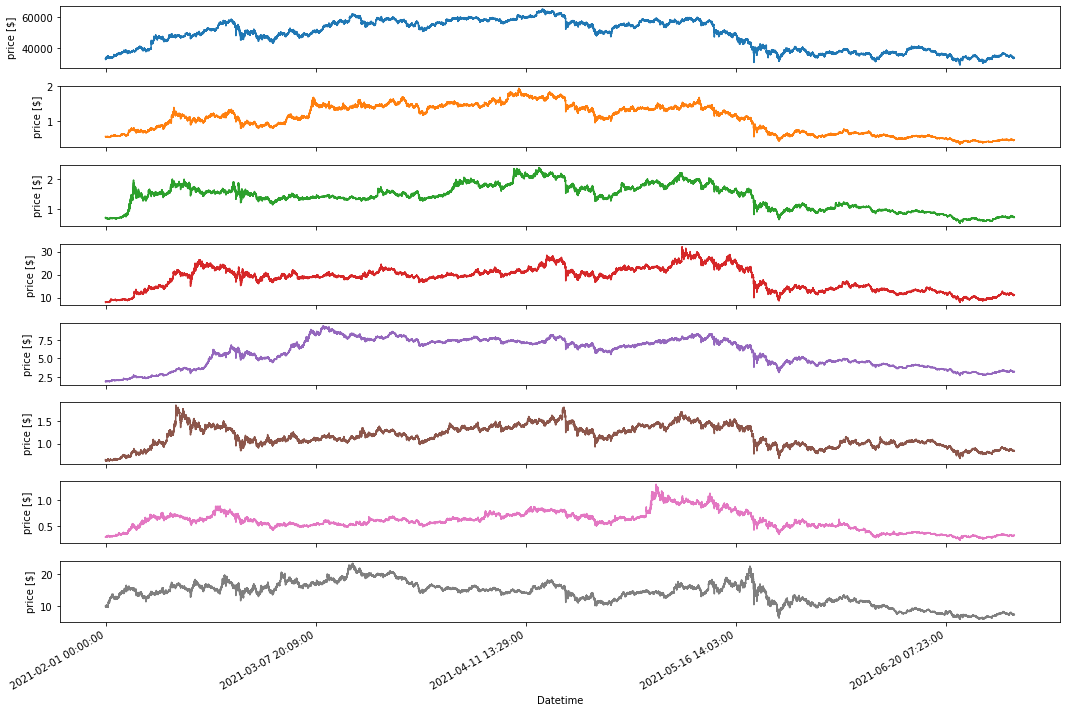

In [12]:
main_df.plot(subplots=True, legend = False, xlabel="Datetime", ylabel="price [$]")
plt.tight_layout()
plt.show()

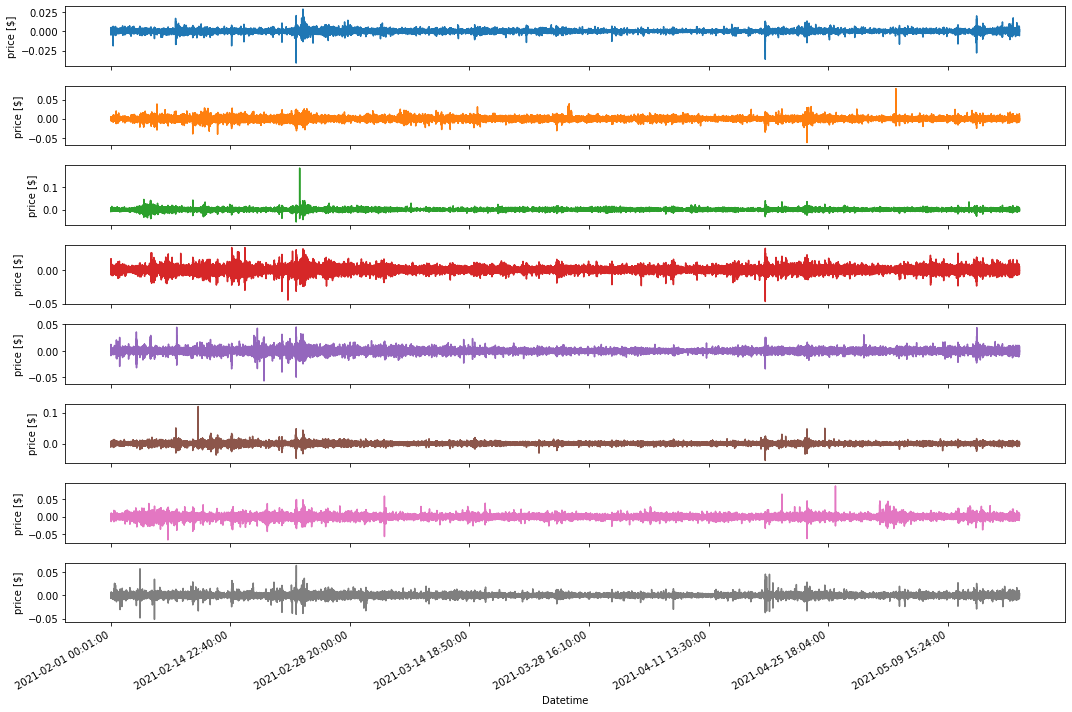

In [156]:
main_df[:152000].plot(subplots=True, legend = False, xlabel="Datetime", ylabel="price [$]")
plt.tight_layout()
plt.show()

In [13]:
main_df.describe()

,BTCBUSD_close,OCEANBUSD_close,ZRXBUSD_close,ATOMBUSD_close,BNTBUSD_close,ALGOBUSD_close,TWTBUSD_close,SUSHIBUSD_close
count,216177.00000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000,216177.000000
mean,48114.12975,1.062732,1.402031,18.256147,5.709224,1.158394,0.591984,14.100699
std,9384.01731,0.409759,0.423119,4.955177,1.896858,0.231497,0.183367,3.556966
min,28860.09000,0.323200,0.499100,7.838000,1.827600,0.618900,0.230000,6.002000
25%,37930.03000,0.635400,1.039800,13.759000,4.017700,0.995500,0.494100,11.761000
50%,49735.22000,1.120100,1.437700,19.243000,6.120700,1.135800,0.588200,14.694000
75%,56629.16000,1.417500,1.714000,21.784000,7.392400,1.352600,0.695000,16.394000
max,64842.71000,1.938500,2.403700,32.125000,9.363300,1.844800,1.301700,23.411000


Some more info with .info()

In [14]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 216177 entries, 2021-02-01 00:00:00 to 2021-07-01 12:59:00
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BTCBUSD_close    216177 non-null  float64
 1   OCEANBUSD_close  216177 non-null  float64
 2   ZRXBUSD_close    216177 non-null  float64
 3   ATOMBUSD_close   216177 non-null  float64
 4   BNTBUSD_close    216177 non-null  float64
 5   ALGOBUSD_close   216177 non-null  float64
 6   TWTBUSD_close    216177 non-null  float64
 7   SUSHIBUSD_close  216177 non-null  float64
dtypes: float64(8)
memory usage: 14.8+ MB


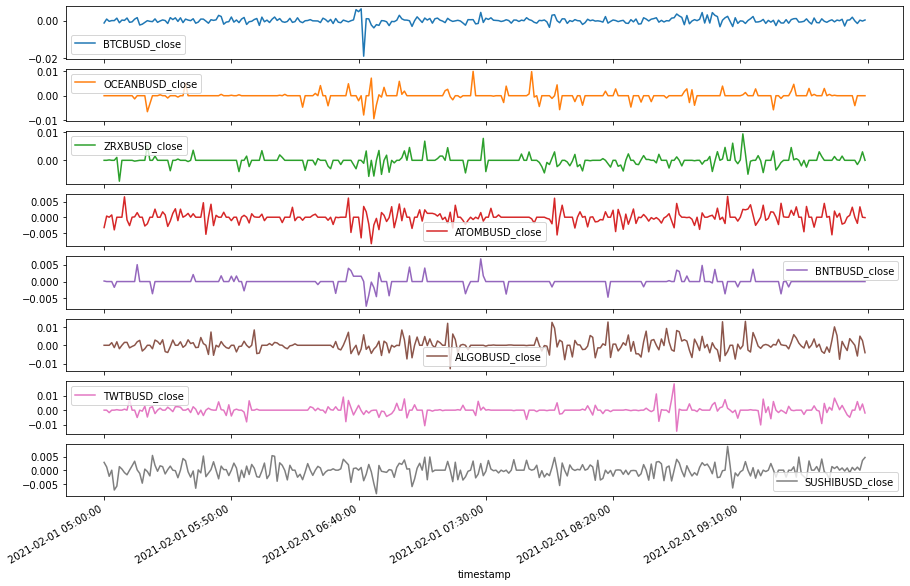

In [15]:
main_df = main_df.pct_change().copy() 
main_df[300:600].plot(subplots=True)
main_df = main_df[1:]
plt.show()

## Splitting data
It is common to split datasets into 3 parts. One is called training set and is uset for training our models. Another part is called validation set and after trainig we evaluate our model using this set and eventually change our model settings. After our model is done we will chceck results on thirs set which is calles test set. This last set is supposed to be uknown for our model so it should behave like "real world" data. We should pick model which does the best job with test set.

I will split main df into 3 parts with this ratio: (70%, 20%, 10%) train, validation, test.

In [16]:
def split_dataset(df):
    
    """
    Function returns train, validation and test dataframes. In ratio 70:20:10.

    Parameters
    ----------
    df: DataFrame
        DataFrame we would like to split

    Returns
    ----------
    Three dataframes.
    """
    
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    return train_df, val_df, test_df

In [17]:
#column_indices = {name: i for i, name in enumerate(df.columns)}
num_features = main_df.shape[1]

In [18]:
train_df_d, val_df_d, test_df_d = split_dataset(main_df)

## Normalizing data
Our model could work even without normalizing, but it improves training ability and performance. My data has different scales, for that reason I need to normalize it.

##### Z-score

In [19]:

from sklearn.preprocessing import StandardScaler
scaler_d = StandardScaler()  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

train_df_d = pd.DataFrame(scaler_d.fit_transform(train_df_d),columns = train_df_d.columns)
val_df_d = pd.DataFrame(scaler_d.transform(val_df_d),columns = val_df_d.columns)
test_df_d = pd.DataFrame(scaler_d.transform(test_df_d),columns = test_df_d.columns)

#joblib.dump(scaler_d, "scalers/scaler_big_pct.gz") 


""" 
scaler_my = StandardScaler()

train_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)

scaler_my = StandardScaler()

train_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)
val_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)
test_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)
"""

' \nscaler_my = StandardScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)\n\nscaler_my = StandardScaler()\n\ntrain_df_my = pd.DataFrame(scaler_my.fit_transform(train_df_my),columns = train_df_my.columns)\nval_df_my = pd.DataFrame(scaler_my.transform(val_df_my),columns = val_df_my.columns)\ntest_df_my = pd.DataFrame(scaler_my.transform(test_df_my),columns = test_df_my.columns)\n'

### Data windowing

Models will make predictions using part of data called windows. 


In [20]:
class WindowGenerator():
    
    """
    Moving window class. Contains needed dataframes for training. 

    Parameters
    ----------
    input_width: int
        Dataframe we would like to split.
        
    input_width: int
        Width of window part model is supposed to predict.
        
    shift: int
        Shift between input and label.
        
    train_df: DataFrame
        Training dataframe
        
    val_df: DataFrame
        Validation dataframe
        
    test_df: DataFrame
        Test dataframe
    
    label_columns: 
        label column indices
    """
    
    
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        # This part takes arguemntes and calculate window size
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        

        # Window size is equal to input width and shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width) # slice(0, i_w, None)
        
        # np.arange(5) -> array([0, 1, 2, 3, 4])
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

Code below splits data inside window class into inputs and labels.
Inputs are data from which our model is supposed to predict label, 
which is the actual correct value.

In [21]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :] 
    # (whole, input_slice, whole): (3, 12, 4) -> i_s=5 (3,5,4)
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [22]:
w2 = WindowGenerator(input_width=30, label_width=1, shift=2,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d, label_columns=['BTCBUSD_close'])
w2


Total window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [31]
Label column name(s): ['BTCBUSD_close']

In [23]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df_d[:w2.total_window_size]),
                           np.array(train_df_d[100:100+w2.total_window_size]),
                           np.array(train_df_d[200:200+w2.total_window_size])])


In [24]:

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 32, 8)
Inputs shape: (3, 30, 8)
labels shape: (3, 1, 1)


Simple vizualization of the split window with function plot().

In [25]:
w2.example = example_inputs, example_labels

In [26]:
def plot(self, model=None, plot_col=RATIO_TO_PREDICT+'_close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs) # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-tensorflow
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
        
    plt.xlabel('Time [min]')

WindowGenerator.plot = plot

In [27]:
def plot_input_data(self,  model=None):
    inputs, labels = self.example
    
    print(inputs)
    plot(inputs)
    
WindowGenerator.plot_input_data = plot_input_data

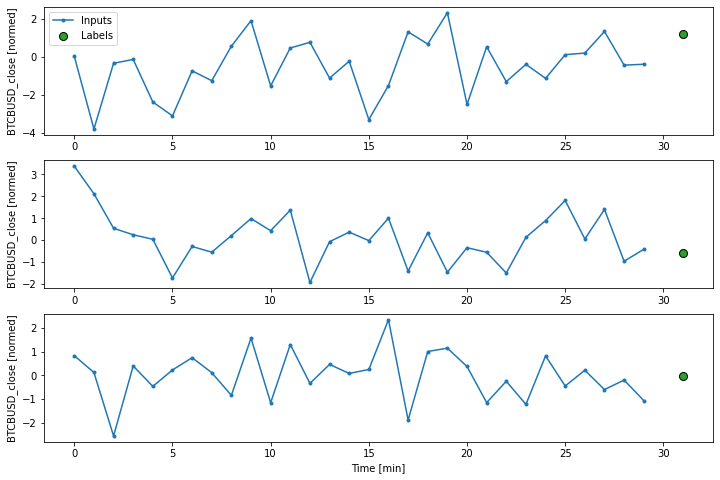

In [28]:
w2.plot()

#### Create dataset

Function below takes dataframe and converts it to tf.data.Dataset with (input_window, label_window) pairs.
First, we convert dataframe to np.array and then timeseries_dataset_from_array function converts it to dataset. 

In [29]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32) # convert data to np.array
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
      # very useful function which converts data to dataset (input_window, label_window) from array

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset


In [30]:
@property  # https://www.python-course.eu/python3_properties.php
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#### Define wide window

In [31]:
wide_window_d = WindowGenerator(
    input_width=30, label_width=30, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])

#### To compare prediction performances

In [32]:
val_performance = {}
performance = {}

## Models

MyModel class to make working with models easier. 

In [216]:
from tensorflow.keras.models import load_model

class MyModel():
    
    def __init__(self, model):
        self.model = model
        
    def load_model(self, dir_name):
        self.model = load_model(dir_name)
    
    def eval_mod(self, window, verbose):
        res = self.model.evaluate(window, verbose=verbose)
        print("Loss:", res[0], "MAE:", res[1])
        
    def save_model(self, name):
        self.model.save("models_pct\\models_18_07_2021_big\\"+ name +".model")
        
    def retrain_model(self, window, patience, epochs):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
        history = self.model.fit(window.train, epochs=epochs, validation_data=window.val, callbacks=[early_stopping])
        self.history = history
        
    def compile_and_fit(self, window, patience=3, epochs=120):

        ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=patience,
                                                        mode="min", restore_best_weights=True)
        
        # https://github.com/Jaewan-Yun/optimizer-visualization
        # https://www.tensorflow.org/api_docs/python/tf/keras/Model
        opt = tf.optimizers.Adam()
        
        self.model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=opt,
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = self.model.fit(window.train, epochs=epochs,
                          validation_data=window.val,
                          callbacks=[early_stopping])
        return history


In [34]:
""" 
Ftrl(
    learning_rate=0.01, learning_rate_power=-0.5, initial_accumulator_value=0.1,
    l1_regularization_strength=0.02, l2_regularization_strength=0.02,
    name='Ftrl', l2_shrinkage_regularization_strength=0.02, beta=0.5)
"""

" \nFtrl(\n    learning_rate=0.01, learning_rate_power=-0.5, initial_accumulator_value=0.1,\n    l1_regularization_strength=0.02, l2_regularization_strength=0.02,\n    name='Ftrl', l2_shrinkage_regularization_strength=0.02, beta=0.5)\n"

#### Training procedure
Because we will train more models let's create function which compiles and train desired model.

To plot learning process there is a function below.

In [35]:
MAX_EPOCHS = 120

def compile_and_fit(model, window, patience=5):

    ## callbacks list https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min', restore_best_weights=True)

    # https://github.com/Jaewan-Yun/optimizer-visualization
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model

    
    model.compile(loss=tf.losses.LogCosh(),
                optimizer=opt,
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [36]:
def plot_loss(history, graph_param):
    plt.plot(history.history[str(graph_param)], label=str(graph_param))
    plt.plot(history.history['val_'+ str(graph_param)], label='val_' + str(graph_param))
    plt.xlabel('Epoch')
    plt.ylabel(graph_param)
    plt.legend()
    plt.grid(True)

To save model I created function below.

In [37]:
def save_model(model, name):
    model.save("models_21_03_2021\\"+ name +".model")
    # https://www.tensorflow.org/api_docs/python/tf/keras/Model#save
    """
    save(filepath, overwrite=True, include_optimizer=True, save_format=None,signatures=None, options=None)
    """

### Recurrent neural network (LSTM)

[batch, timesteps, feature] 3D input

In [217]:
act = "tanh"
recurrent_act = "sigmoid"

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [218]:
lstm = MyModel(lstm_model)

In [219]:
history = lstm.compile_and_fit(wide_window_d)

Epoch 1/120
4728/4728 [==============================] - 40s 8ms/step - loss: 0.9641 - mean_absolute_error: 0.6759 - val_loss: 2.6832 - val_mean_absolute_error: 0.9959
Epoch 2/120
4728/4728 [==============================] - 36s 8ms/step - loss: 0.8917 - mean_absolute_error: 0.6666 - val_loss: 2.8462 - val_mean_absolute_error: 1.0132
Epoch 3/120
4728/4728 [==============================] - 36s 8ms/step - loss: 0.8527 - mean_absolute_error: 0.6585 - val_loss: 2.8191 - val_mean_absolute_error: 1.0138
Epoch 4/120
4728/4728 [==============================] - 36s 8ms/step - loss: 0.8252 - mean_absolute_error: 0.6514 - val_loss: 2.8703 - val_mean_absolute_error: 1.0221


In [220]:
val_performance['LSTM'] = lstm.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM'] = lstm.eval_mod(wide_window_d.test, verbose=1)

1351/1351 [==============================] - 6s 4ms/step - loss: 2.6832 - mean_absolute_error: 0.9959
Loss: 2.6831774711608887 MAE: 0.9958736300468445
675/675 [==============================] - 3s 4ms/step - loss: 1.3827 - mean_absolute_error: 0.8026
Loss: 1.3827327489852905 MAE: 0.8025703430175781


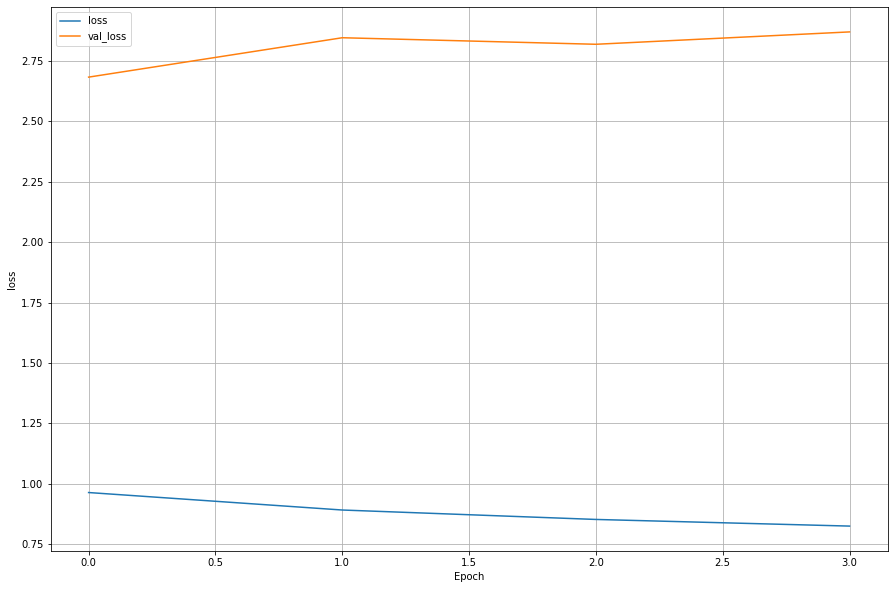

In [221]:
plot_loss(history, 'loss')

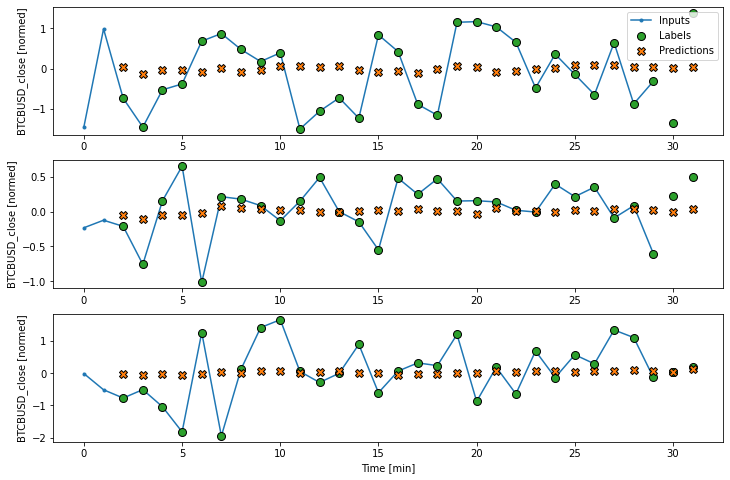

In [222]:
wide_window_d.plot(lstm.model)

In [223]:
lstm.save_model("lstm")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\lstm.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\lstm.model\assets


#### Loading model

In [224]:
lstm.model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 30, 32)            5248      
_________________________________________________________________
lstm_41 (LSTM)               (None, 30, 32)            8320      
_________________________________________________________________
dense_48 (Dense)             (None, 30, 32)            1056      
_________________________________________________________________
dense_49 (Dense)             (None, 30, 1)             33        
Total params: 14,657
Trainable params: 14,657
Non-trainable params: 0
_________________________________________________________________


### Recurrent neural network (LSTM - bidirectional)

Parameters from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [225]:
lstm_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [226]:
lstm_bidi = MyModel(lstm_model_bidirectional)

In [227]:
history = lstm_bidi.compile_and_fit(wide_window_d)

Epoch 1/120
4728/4728 [==============================] - 61s 12ms/step - loss: 0.0998 - mean_absolute_error: 0.1019 - val_loss: 0.2476 - val_mean_absolute_error: 0.1080
Epoch 2/120
4728/4728 [==============================] - 55s 12ms/step - loss: 0.0710 - mean_absolute_error: 0.0738 - val_loss: 0.2333 - val_mean_absolute_error: 0.1085
Epoch 3/120
4728/4728 [==============================] - 55s 12ms/step - loss: 0.0695 - mean_absolute_error: 0.0723 - val_loss: 0.2282 - val_mean_absolute_error: 0.1071
Epoch 4/120
4728/4728 [==============================] - 55s 12ms/step - loss: 0.0685 - mean_absolute_error: 0.0705 - val_loss: 0.2382 - val_mean_absolute_error: 0.1232
Epoch 5/120
4728/4728 [==============================] - 54s 11ms/step - loss: 0.0677 - mean_absolute_error: 0.0697 - val_loss: 0.2624 - val_mean_absolute_error: 0.1040
Epoch 6/120
4728/4728 [==============================] - 54s 11ms/step - loss: 0.0670 - mean_absolute_error: 0.0684 - val_loss: 0.2495 - val_mean_absolute_

In [228]:
val_performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['LSTM-bidi'] = lstm_bidi.eval_mod(wide_window_d.test, verbose=1)

1351/1351 [==============================] - 8s 6ms/step - loss: 0.2282 - mean_absolute_error: 0.1071
Loss: 0.22821113467216492 MAE: 0.10706987231969833
675/675 [==============================] - 4s 6ms/step - loss: 0.0911 - mean_absolute_error: 0.0822
Loss: 0.09108749032020569 MAE: 0.0821983739733696


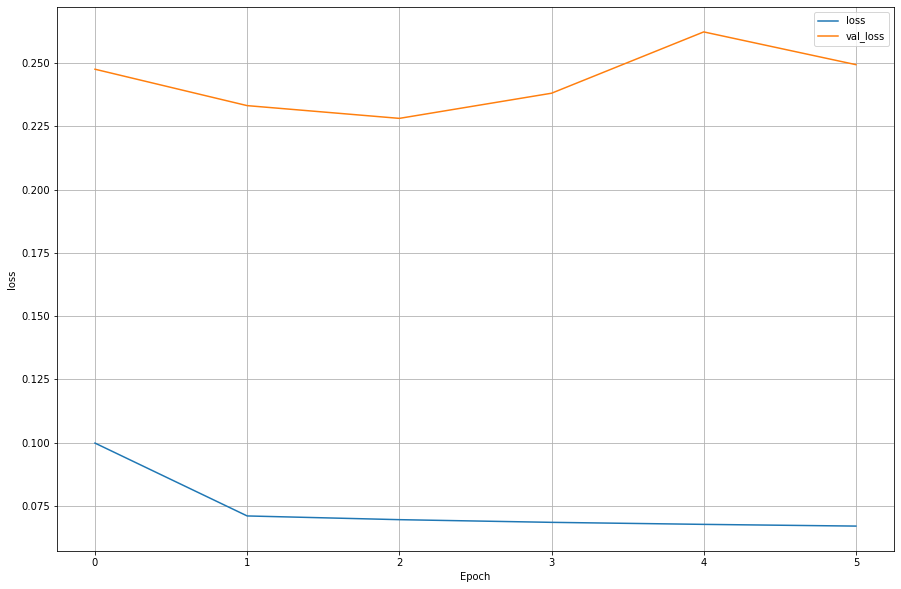

In [229]:
plot_loss(history, 'loss')

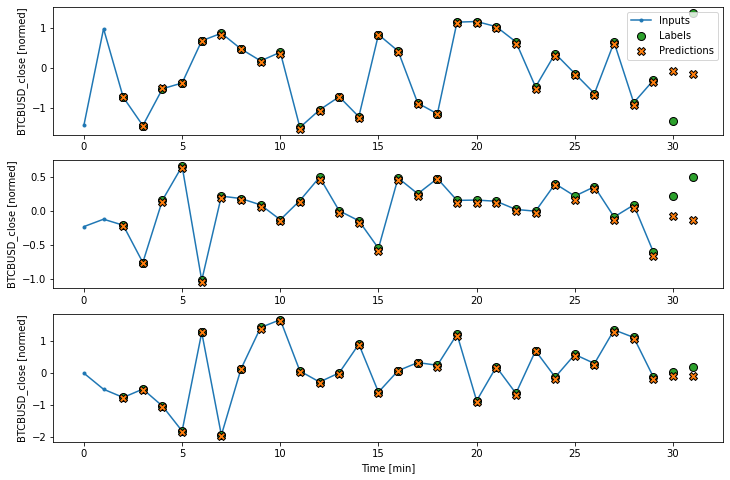

In [230]:
wide_window_d.plot(lstm_bidi.model)

In [231]:
lstm_bidi.save_model("l_bidi")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\l_bidi.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\l_bidi.model\assets


### Recurrent neural network (GRU)

Parameters from: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [232]:
gru_model = tf.keras.models.Sequential([
  
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])


In [233]:
gru = MyModel(gru_model)

In [234]:
history = gru.compile_and_fit(wide_window_d)

Epoch 1/120
4728/4728 [==============================] - 31s 6ms/step - loss: 0.9633 - mean_absolute_error: 0.6765 - val_loss: 2.6611 - val_mean_absolute_error: 0.9972
Epoch 2/120
4728/4728 [==============================] - 29s 6ms/step - loss: 0.8810 - mean_absolute_error: 0.6648 - val_loss: 2.7694 - val_mean_absolute_error: 1.0096
Epoch 3/120
4728/4728 [==============================] - 29s 6ms/step - loss: 0.8394 - mean_absolute_error: 0.6553 - val_loss: 2.8544 - val_mean_absolute_error: 1.0218
Epoch 4/120
4728/4728 [==============================] - 30s 6ms/step - loss: 0.8139 - mean_absolute_error: 0.6486 - val_loss: 2.8729 - val_mean_absolute_error: 1.0273


In [235]:
val_performance['GRU'] = gru.eval_mod(wide_window_d.val, verbose=1)
performance['GRU'] = gru.eval_mod(wide_window_d.test, verbose=1)

1351/1351 [==============================] - 4s 3ms/step - loss: 2.6611 - mean_absolute_error: 0.9972
Loss: 2.6611127853393555 MAE: 0.9971657991409302
675/675 [==============================] - 2s 3ms/step - loss: 1.3529 - mean_absolute_error: 0.7990
Loss: 1.3528892993927002 MAE: 0.799049437046051


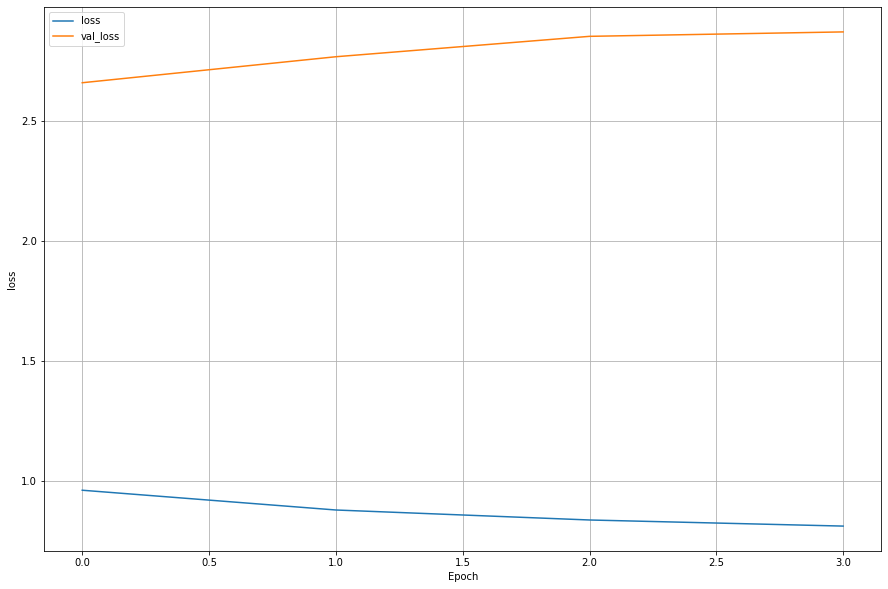

In [236]:
plot_loss(history, 'loss')

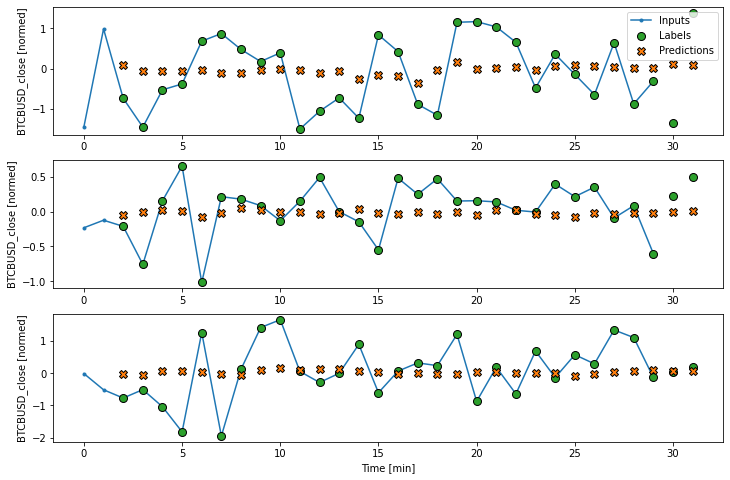

In [237]:
wide_window_d.plot(gru.model)

In [238]:
gru.save_model("gru")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\gru.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\gru.model\assets


### Recurrent neural network (GRU - bidirectional)

In [239]:
gru_model_bidirectional = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
])

In [240]:
gru_bidi = MyModel(gru_model_bidirectional)

In [241]:
history = gru_bidi.compile_and_fit(wide_window_d)

Epoch 1/120
4728/4728 [==============================] - 48s 10ms/step - loss: 0.0963 - mean_absolute_error: 0.1007 - val_loss: 0.2533 - val_mean_absolute_error: 0.1534
Epoch 2/120
4728/4728 [==============================] - 44s 9ms/step - loss: 0.0713 - mean_absolute_error: 0.0736 - val_loss: 0.2293 - val_mean_absolute_error: 0.1424
Epoch 3/120
4728/4728 [==============================] - 44s 9ms/step - loss: 0.0701 - mean_absolute_error: 0.0711 - val_loss: 0.2293 - val_mean_absolute_error: 0.1387
Epoch 4/120
4728/4728 [==============================] - 45s 9ms/step - loss: 0.0694 - mean_absolute_error: 0.0701 - val_loss: 0.2335 - val_mean_absolute_error: 0.1251
Epoch 5/120
4728/4728 [==============================] - 44s 9ms/step - loss: 0.0686 - mean_absolute_error: 0.0686 - val_loss: 0.2572 - val_mean_absolute_error: 0.1319
Epoch 6/120
4728/4728 [==============================] - 44s 9ms/step - loss: 0.0677 - mean_absolute_error: 0.0673 - val_loss: 0.3102 - val_mean_absolute_error

In [242]:
val_performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.val, verbose=1)
performance['GRU-bidi'] = gru_bidi.eval_mod(wide_window_d.test, verbose=1)

1351/1351 [==============================] - 6s 4ms/step - loss: 0.2293 - mean_absolute_error: 0.1387
Loss: 0.22931115329265594 MAE: 0.13874058425426483
675/675 [==============================] - 3s 4ms/step - loss: 0.0955 - mean_absolute_error: 0.1075
Loss: 0.09551523625850677 MAE: 0.10753621906042099


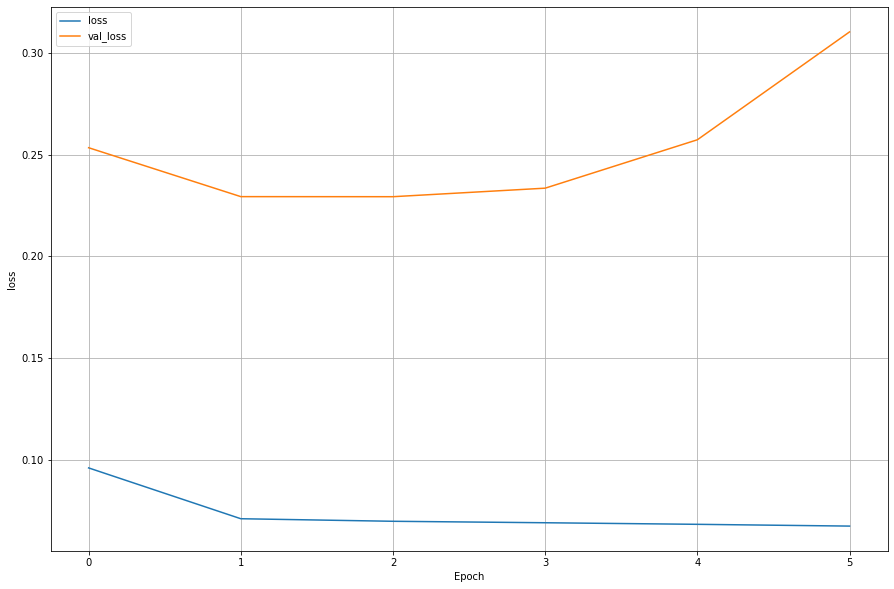

In [243]:
plot_loss(history, 'loss')

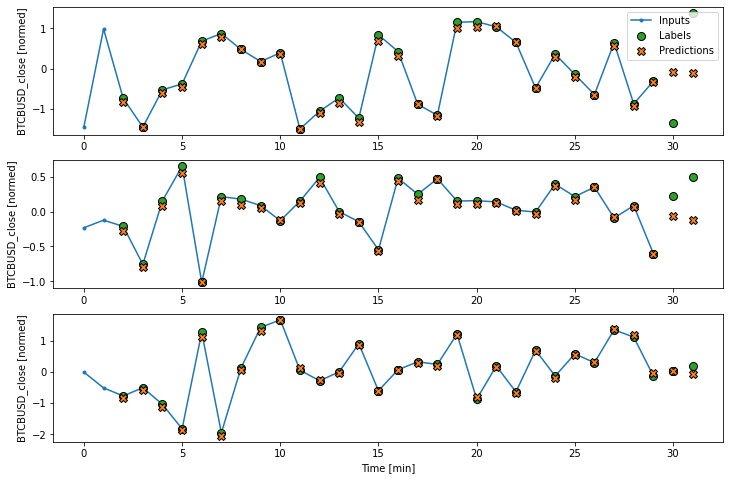

In [244]:
wide_window_d.plot(gru_bidi.model)

In [245]:
gru_bidi.save_model("g_bidi")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\g_bidi.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\g_bidi.model\assets


### Performance

In [246]:
"""
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]


plt.ylabel('mean_absolute_error [BTC-USD, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
"""

"\nx = np.arange(len(performance))\nwidth = 0.3\nmetric_name = 'mean_absolute_error'\nmetric_index = lstm_model.metrics_names.index('mean_absolute_error')\nval_mae = [v[metric_index] for v in val_performance.values()]\ntest_mae = [v[metric_index] for v in performance.values()]\n\n\nplt.ylabel('mean_absolute_error [BTC-USD, normalized]')\nplt.bar(x - 0.17, val_mae, width, label='Validation')\nplt.bar(x + 0.17, test_mae, width, label='Test')\nplt.xticks(ticks=x, labels=performance.keys(),\n           rotation=45)\n_ = plt.legend()\n"

In [247]:
"""
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')
"""

"\nfor name, value in performance.items():\n    print(f'{name:12s}: {value[1]:0.4f}')\n"

## Single shot models
The entire sequence prediction in a single step.

24 min to the future with 2 min to the future

In [248]:
OUT_STEPS = 1

wide_window_d_single = WindowGenerator(
    input_width=30, label_width=OUT_STEPS, shift=FUTURE_PERIOD_PREDICT,train_df = train_df_d,val_df = val_df_d, test_df = test_df_d,label_columns=[RATIO_TO_PREDICT+'_close'])


In [249]:
single_val_performance = {}
single_performance = {}

### LSTM single shot

In [250]:
lstm_model_single = tf.keras.Sequential([
    
    tf.keras.layers.LSTM(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.LSTM(32, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [251]:
lstm_single = MyModel(lstm_model_single)

In [252]:
history = lstm_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
4728/4728 [==============================] - 32s 6ms/step - loss: 1.0010 - mean_absolute_error: 0.6795 - val_loss: 2.4315 - val_mean_absolute_error: 0.9725
Epoch 2/120
4728/4728 [==============================] - 29s 6ms/step - loss: 1.0001 - mean_absolute_error: 0.6791 - val_loss: 2.4309 - val_mean_absolute_error: 0.9722
Epoch 3/120
4728/4728 [==============================] - 29s 6ms/step - loss: 0.9993 - mean_absolute_error: 0.6789 - val_loss: 2.4311 - val_mean_absolute_error: 0.9724
Epoch 4/120
4728/4728 [==============================] - 29s 6ms/step - loss: 0.9977 - mean_absolute_error: 0.6788 - val_loss: 2.4355 - val_mean_absolute_error: 0.9727
Epoch 5/120
4728/4728 [==============================] - 29s 6ms/step - loss: 0.9946 - mean_absolute_error: 0.6786 - val_loss: 2.4400 - val_mean_absolute_error: 0.9737


In [253]:
single_val_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_single'] = lstm_single.eval_mod(wide_window_d_single.test, verbose=1)

1351/1351 [==============================] - 5s 3ms/step - loss: 2.4309 - mean_absolute_error: 0.9722
Loss: 2.43091082572937 MAE: 0.9721839427947998
675/675 [==============================] - 2s 3ms/step - loss: 1.3229 - mean_absolute_error: 0.7948
Loss: 1.322872281074524 MAE: 0.7947894334793091


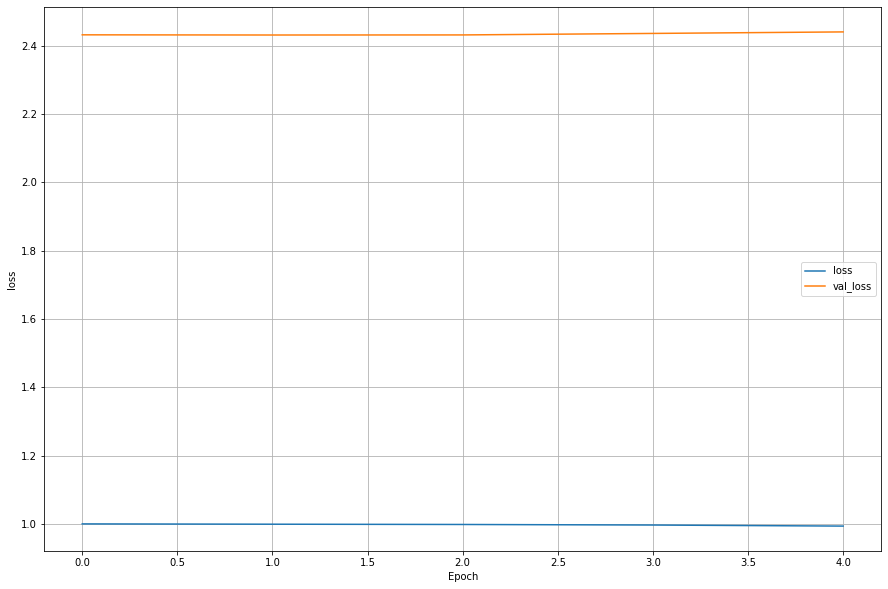

In [254]:
plot_loss(history, 'loss')

In [255]:
lstm_single.save_model("lstm_s")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\lstm_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\lstm_s.model\assets


### LSTM Bidirectional single shot

In [256]:
lstm_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(32, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [257]:
lstm_bidi_single = MyModel(lstm_model_bidirectional_single)

In [258]:
history = lstm_bidi_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
4728/4728 [==============================] - 51s 10ms/step - loss: 1.0016 - mean_absolute_error: 0.6797 - val_loss: 2.4259 - val_mean_absolute_error: 0.9692
Epoch 2/120
4728/4728 [==============================] - 46s 10ms/step - loss: 0.9992 - mean_absolute_error: 0.6790 - val_loss: 2.4238 - val_mean_absolute_error: 0.9686
Epoch 3/120
4728/4728 [==============================] - 46s 10ms/step - loss: 0.9972 - mean_absolute_error: 0.6787 - val_loss: 2.4255 - val_mean_absolute_error: 0.9686
Epoch 4/120
4728/4728 [==============================] - 46s 10ms/step - loss: 0.9940 - mean_absolute_error: 0.6787 - val_loss: 2.4329 - val_mean_absolute_error: 0.9702
Epoch 5/120
4728/4728 [==============================] - 46s 10ms/step - loss: 0.9885 - mean_absolute_error: 0.6783 - val_loss: 2.4375 - val_mean_absolute_error: 0.9713


In [259]:
single_val_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['LSTM_bidi_single'] = lstm_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

1351/1351 [==============================] - 7s 5ms/step - loss: 2.4238 - mean_absolute_error: 0.9686
Loss: 2.4237682819366455 MAE: 0.9686048030853271
675/675 [==============================] - 3s 5ms/step - loss: 1.3199 - mean_absolute_error: 0.7916
Loss: 1.3199052810668945 MAE: 0.7915967702865601


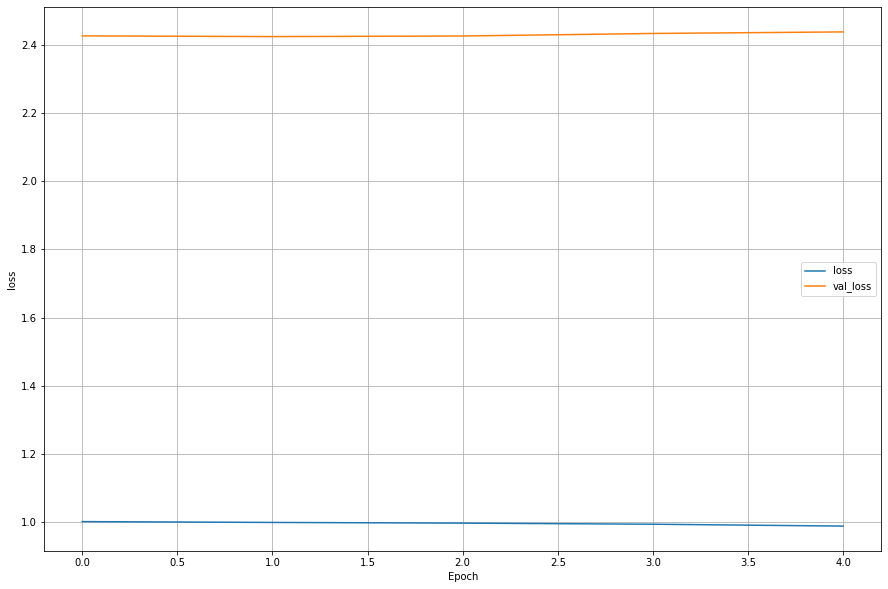

In [260]:
plot_loss(history, 'loss')

In [261]:
lstm_bidi_single.save_model("l_b_s")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\l_b_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\l_b_s.model\assets


### GRU single shot

In [262]:
gru_model_single = tf.keras.models.Sequential([

    tf.keras.layers.GRU(32,  return_sequences=True, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.GRU(32, activation=act, recurrent_activation=recurrent_act),
    tf.keras.layers.Dense(32, activation=act),
    tf.keras.layers.Dense(units=1)
    
])


In [263]:
gru_single = MyModel(gru_model_single)

In [264]:
history = gru_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
4728/4728 [==============================] - 26s 5ms/step - loss: 1.0023 - mean_absolute_error: 0.6801 - val_loss: 2.4338 - val_mean_absolute_error: 0.9708
Epoch 2/120
4728/4728 [==============================] - 24s 5ms/step - loss: 1.0007 - mean_absolute_error: 0.6795 - val_loss: 2.4288 - val_mean_absolute_error: 0.9698
Epoch 3/120
4728/4728 [==============================] - 24s 5ms/step - loss: 0.9992 - mean_absolute_error: 0.6791 - val_loss: 2.4321 - val_mean_absolute_error: 0.9705
Epoch 4/120
4728/4728 [==============================] - 24s 5ms/step - loss: 0.9977 - mean_absolute_error: 0.6788 - val_loss: 2.4386 - val_mean_absolute_error: 0.9726
Epoch 5/120
4728/4728 [==============================] - 24s 5ms/step - loss: 0.9953 - mean_absolute_error: 0.6787 - val_loss: 2.4420 - val_mean_absolute_error: 0.9727


In [265]:
single_val_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_single'] = gru_single.eval_mod(wide_window_d_single.test, verbose=1)

1351/1351 [==============================] - 3s 2ms/step - loss: 2.4288 - mean_absolute_error: 0.9698
Loss: 2.428846836090088 MAE: 0.969780445098877
675/675 [==============================] - 2s 2ms/step - loss: 1.3210 - mean_absolute_error: 0.7917
Loss: 1.321035385131836 MAE: 0.79166579246521


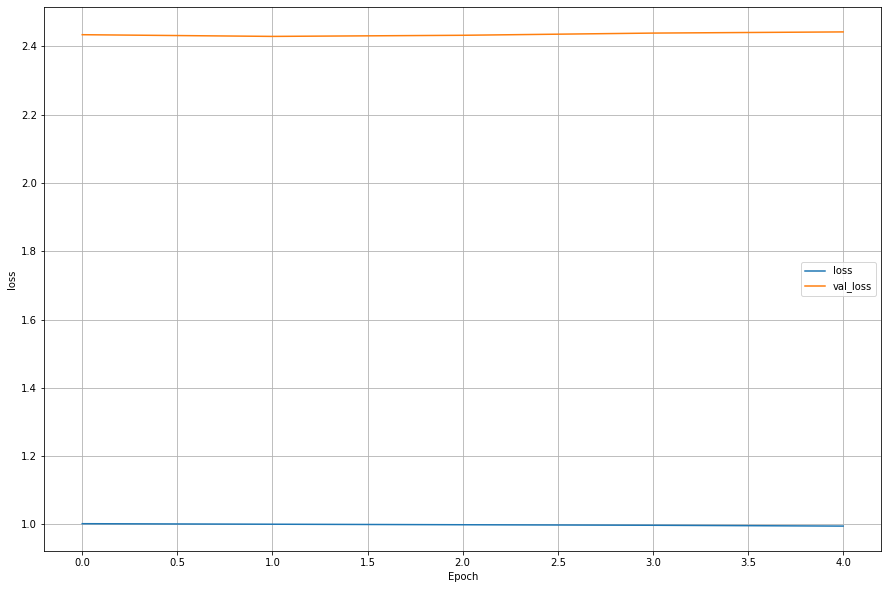

In [266]:
plot_loss(history, 'loss')

In [267]:
gru_single.save_model("gru_s")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\gru_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\gru_s.model\assets


### GRU Bidirectional single shot

In [268]:
gru_model_bidirectional_single = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, activation=act, recurrent_activation=recurrent_act)),
    tf.keras.layers.Dense(32, activation=act),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [269]:
gru_bidi_single = MyModel(gru_model_bidirectional_single)

In [270]:
history = gru_bidi_single.compile_and_fit(wide_window_d_single)

Epoch 1/120
4728/4728 [==============================] - 44s 9ms/step - loss: 1.0035 - mean_absolute_error: 0.6809 - val_loss: 2.4283 - val_mean_absolute_error: 0.9711
Epoch 2/120
4728/4728 [==============================] - 38s 8ms/step - loss: 1.0004 - mean_absolute_error: 0.6794 - val_loss: 2.4303 - val_mean_absolute_error: 0.9718
Epoch 3/120
4728/4728 [==============================] - 38s 8ms/step - loss: 0.9989 - mean_absolute_error: 0.6791 - val_loss: 2.4297 - val_mean_absolute_error: 0.9716
Epoch 4/120
4728/4728 [==============================] - 37s 8ms/step - loss: 0.9970 - mean_absolute_error: 0.6788 - val_loss: 2.4335 - val_mean_absolute_error: 0.9731


In [271]:
single_val_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.val, verbose=1)
single_performance['GRU_bidi_single'] = gru_bidi_single.eval_mod(wide_window_d_single.test, verbose=1)

1351/1351 [==============================] - 5s 4ms/step - loss: 2.4283 - mean_absolute_error: 0.9711
Loss: 2.428346633911133 MAE: 0.9710513949394226
675/675 [==============================] - 2s 3ms/step - loss: 1.3218 - mean_absolute_error: 0.7937
Loss: 1.3218327760696411 MAE: 0.7937222123146057


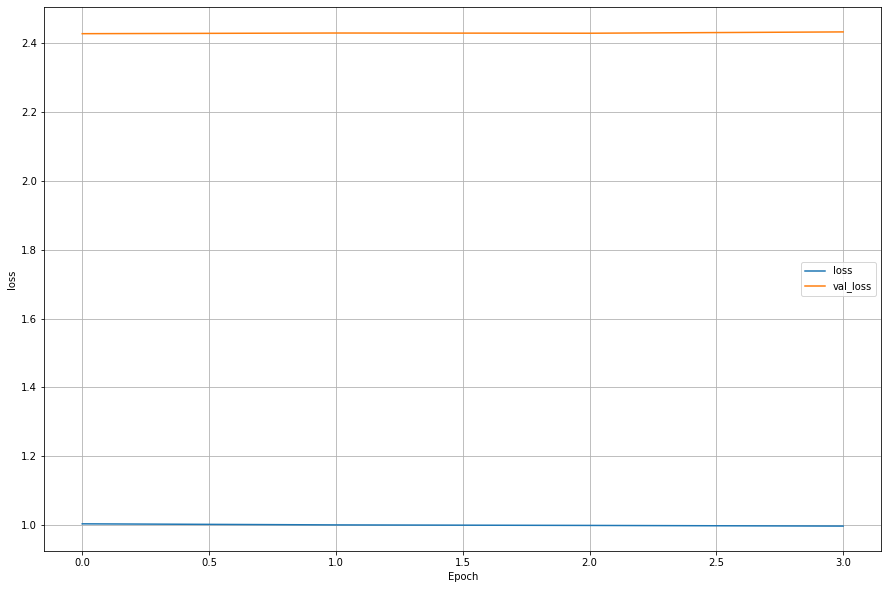

In [272]:
plot_loss(history, 'loss')

In [273]:
gru_bidi_single.save_model("g_b_s")

INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\g_b_s.model\assets


INFO:tensorflow:Assets written to: models_pct\models_18_07_2021_big\g_b_s.model\assets
